# Statement of the problem

Our goal is to build a framework to study some discrete nonlinear dynamical systems and their chaotic behaviour from a numerical point of view using the Julia Programming Language. We will

1. apply this framework to the logistic map: $x_{n+1}=4r(1-x_n)x_n$ as a test
2. study two alternative unimodal maps: the tent map, and the sine map. We will observe similarities and differences
3. verify which of these characteristics are preserved in the case of a non-unimodal map: a bimodal map which we will construct as two side-by-side logistic maps.


**Notes:**
1. The visualizations of the bifurcation diagrams are shown in a lightweight version, where non-periodical orbits are not included. To achieve more visually appealing and resource-intensive representations, set the `include_non_periodic` keyword argument to `true`, or delete it altogether, since its default value is `true`.
2. The function to `Lyapunov_average` implements different ways of computing the Lyapunov exponent, accessible through the `mode` keyword argument: the `"numerical"` mode is based on the formula:
   $$
   \lambda = \lim_{n\to\infty}\frac 1n\sum_{i=0}^{n-1}\ln\left|\frac{\Delta x_{i+1}}{\Delta x_i}\right|,
   $$
   while the `"analytical"` mode relies on the analytical calculation of the derivative of the map, through the formula:
   $$
   \lambda = \lim_{n\to\infty}\left(\frac{1}{n}\sum_{i=0}^{n-1}\ln|f'(x_i)|\right).
   $$
   These limits are true only for convergence to periodic orbits, but they can be extended to chaotic orbits with some limitations. 
   
   While the `"numerical"` mode is more flexible, it has the disadvantage that the computation of the Lyapunov exponent has to be optimized differently for the case of periodic orbits (where exponential convergence is best represented on the long run) vs chaotic ones (where exponential divergence is only realistic in the first steps due to fact that the orbit itself is limited). 
   
   `"analytical"` mode, on the other hand, has the disadvantage that each map has to be accompanied by its analytical derivative, but the advantage that, since derivatives are oblivious of the orbit's limitedness, the implementation is stable on the long run, also for chaotic orbits. The basic implementation I propose is unable to handle the difference for the numerical case in an efficient way, so I chose to use the analytical method throughout this notebook.

# Basic functions

The functions to compute relevant quantities regarding the dynamical systems are defined in a separate file to keep this one more readable. They are imported through the Julia module system and their documentation is still accessible:

In [3]:
(@isdefined LogisticMaps) || include("logistic_maps.jl") # Only import the module once, otherwise there will be conflicts
using .LogisticMaps

In [2]:
?LogisticMaps.maps #The dictionary is not exported, so we must reference it with the module name

Dictionary containing all the available maps.

Implemented keys: "logistic", "tent", "sine", "bimodal".


In [3]:
?logistic_map #The function is exported, so its name is available for direct use

search: logistic_map



```
logistic_map(x₀, r, N_steps; map="logistic")
```

Run the dynamical system associated to a `map` from [`maps`](@ref) (defaults to `"logistic"`), starting from point `x₀`, with parameter `r`, for `N_steps` discrete steps.  Return a vector containing all visited positions.


# Test Case: Logistic Map

## Convergence at equilibrium

We can analytically compute that, for $r=1/3$ and $r=1/2$, $1/4$ and $1/2$ will respectively be equilibrium points. We can see numerically that they are stable:

In [4]:
using Random
using Plots

r₁= 1/3
x₀₁= rand(MersenneTwister(1233), 10) .* .74 .+ 1/4

r₂ = .5
x₀₂= rand(MersenneTwister(1233),10) .* .49 .+ 1/2;

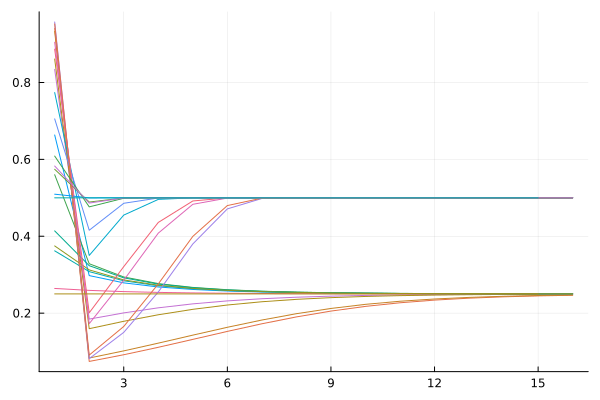

[ Info: Saved animation to d:\Università\Magistrale\Computazionale\esame\tmp.gif


Plots.AnimatedGif("d:\\Università\\Magistrale\\Computazionale\\esame\\tmp.gif")
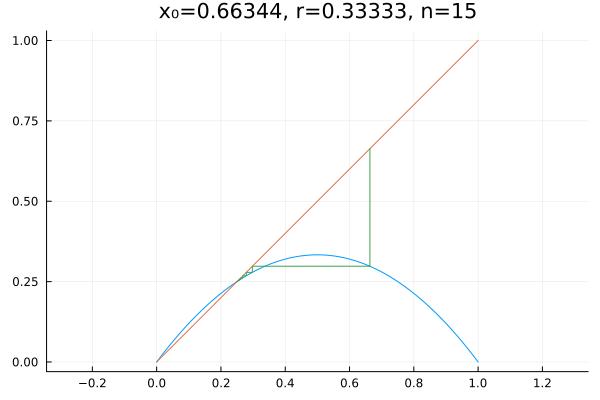

In [5]:
p = plot(legend=false)
map(x-> plot!(p,x), vcat(logistic_map.(x₀₁, r₁, 15), logistic_map.(x₀₂, r₂, 15)))
plot!(1:15, ones(15) * 1/4)
plot!(1:15, ones(15) * 1/2)

display(p)

@gif for x in x₀₁ 
    draw_cobweb(logistic_map(x, r₁, 15),r₁)
end fps = 5

## Fixed points and periodic orbits

We can study the presence of fixed equilibrium points or periodic orbits and plot them as a function of the parameter $r$:

In [11]:
points = vcat([fixed_points_as_tuples(r, n=1000, map="logistic", include_non_periodic=false) for r in 0.7:.0005:1]...);

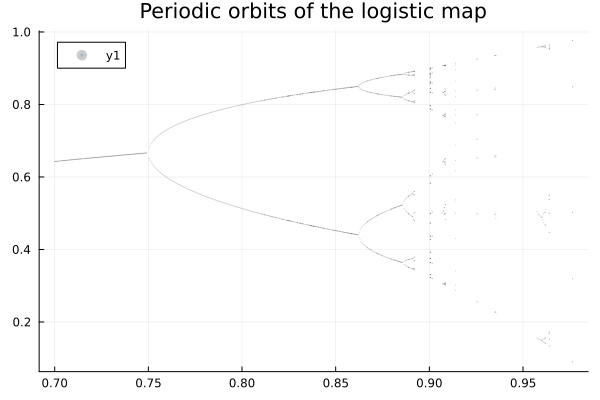

In [12]:
using Plots
using InspectDR
plt = scatter(points, ms=.2, ma=.2, title="Periodic orbits of the logistic map")

We can see that the stable equilibrium point, initially at $x=0$ (I'm not showing that part for visualization reasons. It's clearly visible, e.g. in ), shifts to higher values ($x=0$ remains an unstable equilibrium point), until it starts following a bifurcation pattern that quickly leads to chaos, followed by isolated windows of stable equilibrium which quickly undergo bifurcation with the same pattern. 

The succession of multiplicities of stable equilibrium points looks highly unpredictable: stability regions have highly irregular extensions, so there is no hope of thoroughly characterizing their succession with simple numerical methods. Since bifurcation is poorly described by the actual measured periodicity of the system (see following plot: numerical errors lead to single points being counted twice), we can resort to the Lyapunov exponent as a tool to study this situation.

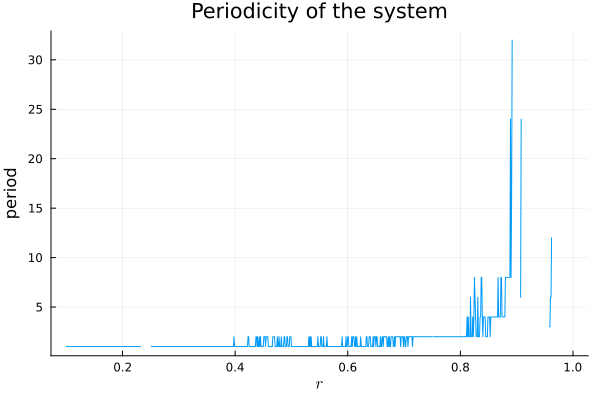

In [8]:
using Plots
plot(0.1:0.001:1, find_period.(0.1:0.001:1) .|> x-> x[1], legend=false, ylabel = "period", xlabel="\$r\$", title = "Periodicity of the system")

## Lyapunov exponents and bifurcation points

To characterize the chaos of the dynamical system, we can compute the Lyapunov exponent as a function of the parameter $r$:

In [136]:
δr = .0002
r_range = 0.7:δr:1
exponents = map(r -> Lyapunov_average(0.1:.001:.99, r, start=10, map="logistic"), r_range);

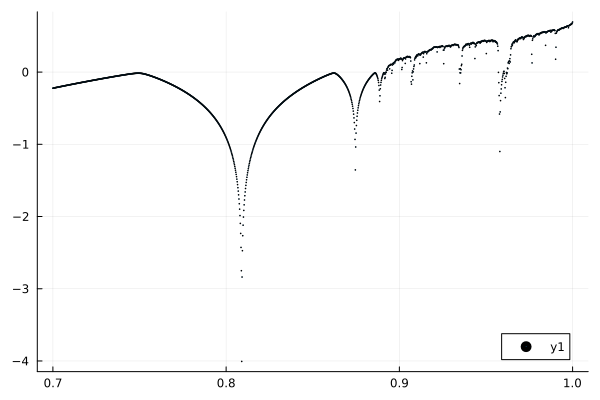

In [112]:
scatter(r_range, exponents, ms=.5)

As the Lyapunov exponent approaches $0$, the stability of the equilibrium points or periodic orbits weakens. This suggests that the presence of peaks in the negative regions of Lyapunov exponents correspond to bifurcation points. We can detect these peaks by numerical methods, and thus calculate the position of the bifurcation points with some desired precision $\delta r$. We wrap everything up into a function so that we can use it also for other maps:

In [60]:
function findnegativelocalmaxima(array)
    result=[]
    for i in eachindex(array)[begin+1:end-1]
        if array[i-1] ≤ array[i] ≥ array[i+1] && array[i] ≤ 0
            push!(result, i)
        end
    end
    result
end

"Study the bifurcation points of the dynamical system, and plot them against"
function study_bifurcations(exponents, r_range, plt)
    #Copy the fixed points' plot
    plt2=plot(plt)

    bifurcation_points = r_range[findnegativelocalmaxima(exponents)]
    for r in bifurcation_points
        plot!(plt2, [(r,0),(r,1)], label=false)
    end
    display(plt2)
    return bifurcation_points
end

study_bifurcations

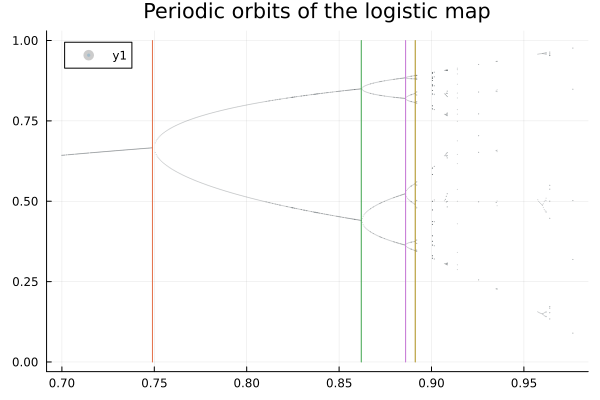

4-element Vector{Float64}:
 0.749
 0.862
 0.886
 0.8912

In [137]:
bifurcation_points = study_bifurcations(exponents, r_range, plt)

This method works well at least for the first four bifurcation points. Note that numerical noise in the Lyapunov exponents may translate into artifacts in the calculations of the local maxima due to spurious oscillations. Therefore, an increase in the precision of the bifurcation point's localization (smaller $\delta r$) must correspond to an increase in the number of paths on which the Lyapunov exponent is averaged. I found that a value of $\delta r= 2\cdot 10^{-4}$, corresponding to three significant digits on the bifurcation points, gives the optimal compromise between speed and precision. Smaller values (e.g. half) cause artifacts or require more paths for the Lyapunov average. Furthermore, the calculated values for the exponents significantly depend on the `start` and `stop` parameters, so we must take our results with a grain of salt.

In any case, I wasn't able to calculate the position of the fifth bifurcation point. This makes sense since the distance between bifurcation points decreases roughly exponentially, as we can start seeing already from the first points:

In [185]:
# Compute the distances between bifurcation points
lengths = diff(bifurcation_points[1:4])

# Semilog plot of the distances
scatter(lengths, yscale=:log10, ylabel="distances", label = "distances")

# Find the exponent by linear fit on the logarithm
using EasyFit
fit = fitlinear(1:3,log.(lengths))

------------------- Linear Fit -------------

Equation: y = ax + b

With: a = -1.5393645965626817
      b = -0.6443259943075201

Pearson correlation coefficient, R = 0.9999930096561934
Average square residue = 2.2086393977788065e-5

Predicted Y: ypred = [-2.183690590870202, -3.7230551874328834, ...]
residues = [-0.003323130600405566, 0.00664626120130718, ...]

--------------------------------------------


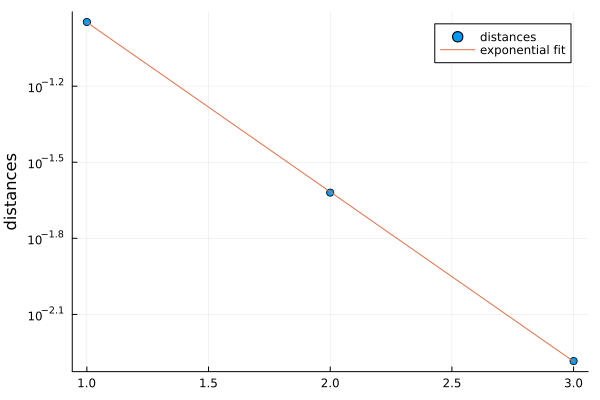

The exponent is: 4.6616273157319235


In [186]:
display(plot!([(1, exp(fit.a+fit.b)),(3,exp(3fit.a+fit.b))], label = "exponential fit"))

println("The exponent is: $(exp(-fit.a))")

# Other unimodal maps

We study two additional unimodal maps: the sine map,
$$
x_n = r \sin(\pi x)
$$
and the tent map,
$$
x_n = \begin{cases}2r x & 0\leq x \leq 0.5\\ 2r(1 - x) & 0.5<x\leq 1.\end{cases}
$$
Note that we redefined the classical tent map with a factor of $2$, so that for all maps the range for $r$ is $(0,1)$. Let us carry on the same study as for the logistic map, and spot any similarities or differences between the three cases.

In [129]:
points_sine = vcat([fixed_points_as_tuples(r, n=1000, map="sine", include_non_periodic=false) for r in 0.7:.0002:1]...);
points_tent = vcat([fixed_points_as_tuples(r, n=1000, map="tent", include_non_periodic=false) for r in 0.1:.005:1]...);

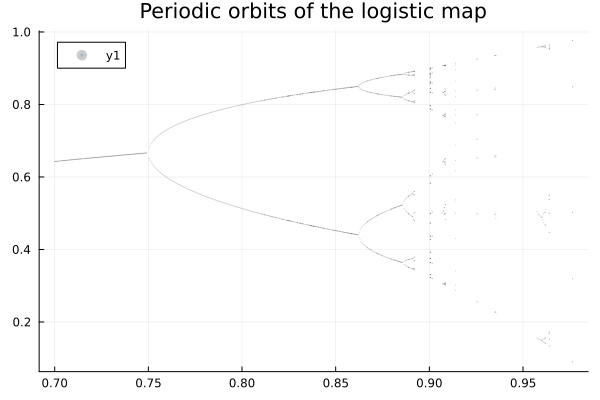

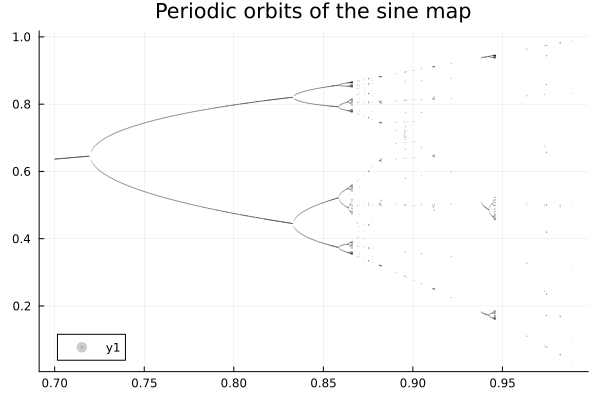

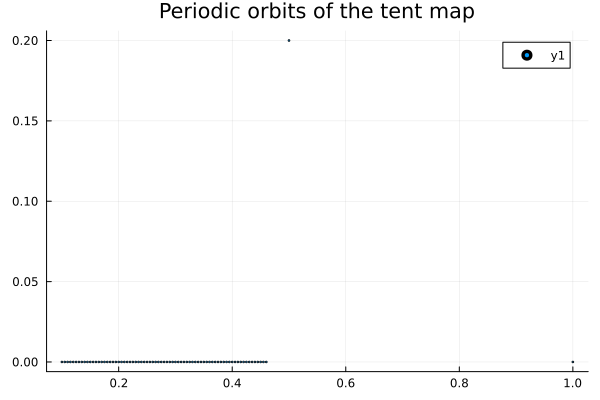

In [130]:
using Plots
using InspectDR
display(plt)
plt_sine = scatter(points_sine, ms=.2, ma=.2, title="Periodic orbits of the sine map")
plt_tent = scatter(points_tent, ms=1, title="Periodic orbits of the tent map")

display(plt_sine)
display(plt_tent)

As for similarities, we immediately see that all three maps have a region where $x=0$ is a stable equilibrium point. This equilibrium then shifts toward a higher value before bifurcation occurs. 

In the case of the sine map, there is an incredible resemblance to the sine map. The bifurcation diagram looks like a deformed version of the logistic map's diagram. The same regions of stability and chaos are present and the bifurcation pattern appears identical.

In the case of the tent map, though, there seems to be no bifurcation at all, and, after a discontinuous shift of the equilibrium point away from $x=0$, no equilibrium is found at all.

These observations can be seen more clearly through the Lyapunov exponents:

In [120]:
exponents_sine = map(r -> Lyapunov_average(0.1:.001:.99, r, start=10, map="sine"), r_range);
exponents_tent = map(r -> Lyapunov_average(0.1:.01:.99, r, map="tent"), 0.1:.005:1);

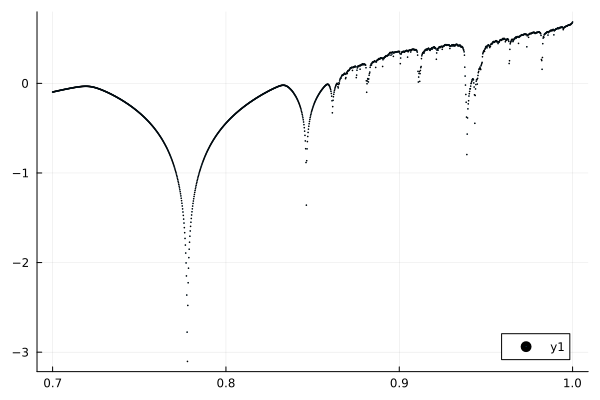

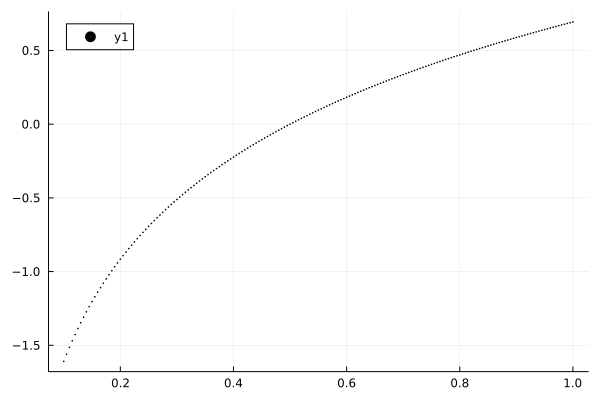

In [118]:
using Plots
display(scatter(r_range, exponents_sine, ms=.5))
display(scatter(0.1:.005:1, exponents_tent, ms=.5))

The tent map shows no local maxima for the Lyapunov exponent in the negative region, indicating the absence of bifurcation. On the other hand, the sine map shows again the same pattern as the logistic map. By studying the bifurcation points, we can see that, though their position and difference varies from the logistic map, their distance decreases again exponentially, and with roughly the same exponent: it is like the bifurcation diagram was stretched while maintaining its proportions. This time, also the fifth bifurcation is found, and the exponential separation can be better viewed and quantified:

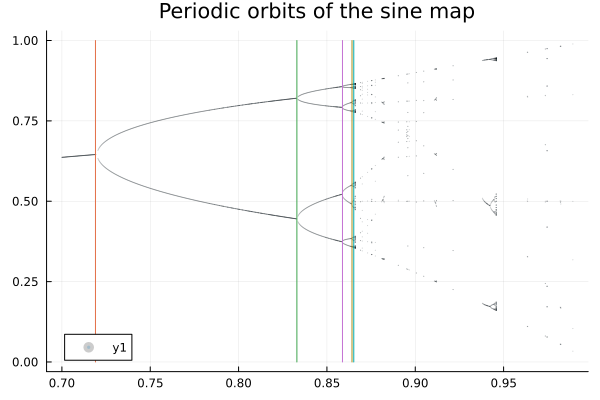

5-element Vector{Float64}:
 0.719
 0.833
 0.8588
 0.8642
 0.8652

In [175]:
bifurcation_sine = study_bifurcations(exponents_sine, r_range, plt_sine)

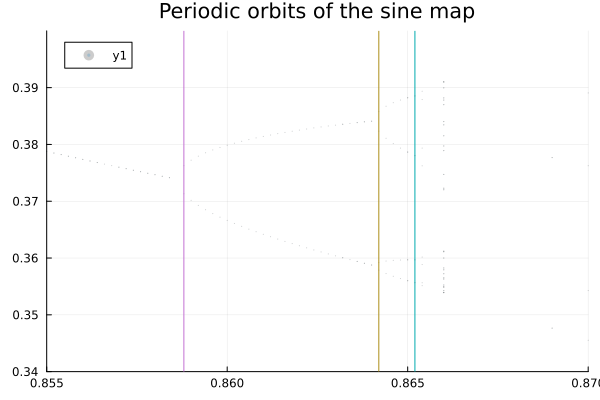

In [179]:
plot!(xlims=(.855,.87), ylims=(.34,.4))

In [180]:
lengths_sine = diff(bifurcation_sine)

# Semilog plot of the distances
scatter(lengths_sine, yscale=:log10, ylabel="distances", label = "distances")

# Find the exponent by linear fit on the logarithm
using EasyFit
fit_sine = fitlinear(1:4,log.(lengths_sine))


------------------- Linear Fit -------------

Equation: y = ax + b

With: a = -1.577257088354869
      b = -0.5463695846214742

Pearson correlation coefficient, R = 0.9995920245675675
Average square residue = 0.0025388955317583763

Predicted Y: ypred = [-2.1236266729763433, -3.7008837613312124, ...]
residues = [0.04793015761129826, -0.04350297427664884, ...]

--------------------------------------------


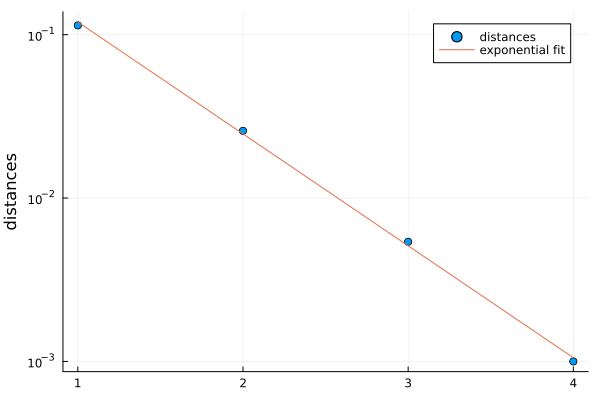

The exponent is: 4.841657343005537


In [181]:
display(plot!([(1, exp(fit_sine.a+fit_sine.b)),(4,exp(4fit_sine.a+fit_sine.b))], label = "exponential fit"))

println("The exponent is: $(exp(-fit_sine.a))")

*Note:* for each bifurcation process, we can construct the succession of the ratios between neighouring bifurcation points' distances. [It has been proven](https://en.wikipedia.org/wiki/Feigenbaum_constants) that this succession has the same limit for all unimodal maps, called the first Feigenbaum constant:
$$
\delta = 4.669201\dots
$$
In other words, the points in the previous plot asyntotically tend to align on a straight line whose pendence is the logarithm of the first Feigenbaum constant and this is true for the logistic map as well. Since the tent map shows no bifurcation, this theorem doesn't hold.

# Bimodal map

In [ ]:
find_fixed_points(1.15, map="bimodal")

In [ ]:
r_range = 0.01:.001:2 
exponents = map(r -> Lyapunov_average(0.1:.1:.99, r, map="bimodal"), r_range);

# Additional images

# Logistic map

<image src="images/unimodal.png"/> <image src="images/logistic_zoom.png">



# Tent map

In [ ]:
display.(
    draw_cobweb.(
        map(
            r -> logistic_map(.3, r,200, map="tent"), 
            [.3,.6,.9]
            ),
        [.3,.6,.9],
        start=1, map="tent"
        )
    )